# Taming Transformers

This notebook is a minimal working example to generate landscape images as in [Taming Transformers for High-Resolution Image Synthesis](https://github.com/CompVis/taming-transformers). **tl;dr** We combine the efficiancy of convolutional approaches with the expressivity of transformers by introducing a convolutional VQGAN, which learns a codebook of context-rich visual parts, whose composition is modeled with an autoregressive transformer.

## Setup
The setup code in this section was written to be [run in a Colab environment](https://colab.research.google.com/github/CompVis/taming-transformers/blob/master/scripts/taming-transformers.ipynb). For a full, local setup, we recommend the provided [conda environment](https://github.com/CompVis/taming-transformers/blob/master/environment.yaml), as [described in the readme](https://github.com/CompVis/taming-transformers#requirements). This will also allow you to run a streamlit based demo.

Here, we first clone the repository and download a model checkpoint and config.

In [1]:
!git clone https://github.com/CompVis/taming-transformers
%cd taming-transformers
!mkdir -p logs/2020-11-09T13-31-51_sflckr/checkpoints
!wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt'
!mkdir logs/2020-11-09T13-31-51_sflckr/configs
!wget 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' -O 'logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml'

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1335, done.
remote: Counting objects: 100% (525/525), done.
remote: Compressing objects: 100% (493/493), done.
remote: Total 1335 (delta 58), reused 481 (delta 30), pack-reused 810
Receiving objects: 100% (1335/1335), 412.35 MiB | 29.91 MiB/s, done.
Resolving deltas: 100% (267/267), done.
/content/taming-transformers
--2022-03-08 09:38:28--  https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1
Resolving heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)... 129.206.7.113
Connecting to heibox.uni-heidelberg.de (heibox.uni-heidelberg.de)|129.206.7.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://heibox.uni-heidelberg.de/seafhttp/files/c83530a3-ffcb-4ac6-965d-0030759fc627/last.ckpt [following]
--2022-03-08 09:38:29--  https://heibox.uni-heidelberg.de/seafhttp/files/c83530a3-ffcb-4ac6-965d-0030759fc627/last.ckpt
Reusing existing connection

Next, we install minimal required dependencies.

In [3]:
%pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 einops transformers
import sys
sys.path.append(".")

## Loading the model

We load and print the config.

In [4]:
from omegaconf import OmegaConf
config_path = "logs/2020-11-09T13-31-51_sflckr/configs/2020-11-09T13-31-51-project.yaml"
config = OmegaConf.load(config_path)
import yaml
print(yaml.dump(OmegaConf.to_container(config)))

data:
  params:
    batch_size: 1
    validation:
      target: taming.data.sflckr.Examples
  target: main.DataModuleFromConfig
model:
  base_learning_rate: 4.5e-06
  params:
    cond_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          double_z: false
          dropout: 0.0
          in_channels: 182
          num_res_blocks: 2
          out_ch: 182
          resolution: 256
          z_channels: 256
        embed_dim: 256
        image_key: segmentation
        lossconfig:
          target: taming.modules.losses.DummyLoss
        n_embed: 1024
      target: taming.models.vqgan.VQModel
    cond_stage_key: segmentation
    first_stage_config:
      params:
        ddconfig:
          attn_resolutions:
          - 16
          ch: 128
          ch_mult:
          - 1
          - 1
          - 2
          - 2
          - 4
          doub

Instantiate the model.

In [5]:
from taming.models.cond_transformer import Net2NetTransformer
model = Net2NetTransformer(**config.model.params)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


Load the checkpoint.

In [6]:
import torch
ckpt_path = "logs/2020-11-09T13-31-51_sflckr/checkpoints/last.ckpt"
sd = torch.load(ckpt_path, map_location="cpu")["state_dict"]
missing, unexpected = model.load_state_dict(sd, strict=False)

In [7]:
model.cuda().eval()
torch.set_grad_enabled(False)

## Load example data

Load an example segmentation and visualize.

In [ ]:
from PIL import Image
import numpy as np
segmentation_path = "data/sflckr_segmentations/norway/25735082181_999927fe5a_b.png"
segmentation = Image.open(segmentation_path)
segmentation = np.array(segmentation)
segmentation = np.eye(182)[segmentation]
segmentation = torch.tensor(segmentation.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)

In [ ]:
from PIL import Image
import numpy as np

from google.colab import drive
drive.mount("/content/drive")

example = "data/sflckr_segmentations/norway/25735082181_999927fe5a_b.png"
example2 = "../drive/MyDrive//4_ING_INFORMATICA/tfg/tfg/experiments/decimer/caffeine.png"
example3 = "../drive/MyDrive//4_ING_INFORMATICA/tfg/tfg/experiments/taming_transformers/caffeine_segmentation.png"

example = Image.open(example)
example2 = Image.open(example2)
# example2 = example2.resize((1100,1100))
example3 = Image.open(example3)

example = np.array(example)
example2 = np.array(example2)
example2 = np.mean(example2, axis=2, dtype=np.int64)
example3 = np.array(example3)

print(example.shape)
print(example2.shape)
print(example3.shape)

example = np.eye(182)[example]
#example2 = np.eye(182)[example2]
example3 = np.eye(182)[example3]

example = torch.tensor(example.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
#example2 = torch.tensor(example2.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)
example3 = torch.tensor(example3.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)

print()
print(example.shape)
#print(example2.shape)
print(example3.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(683, 1024)
(299, 299)
(795, 920)

torch.Size([1, 182, 683, 1024])
torch.Size([1, 182, 795, 920])


Visualize

In [8]:
def show_segmentation(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0,:,:,None,:]
  colorize = np.random.RandomState(1).randn(1,1,s.shape[-1],3)
  colorize = colorize / colorize.sum(axis=2, keepdims=True)
  s = s@colorize
  s = s[...,0,:]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

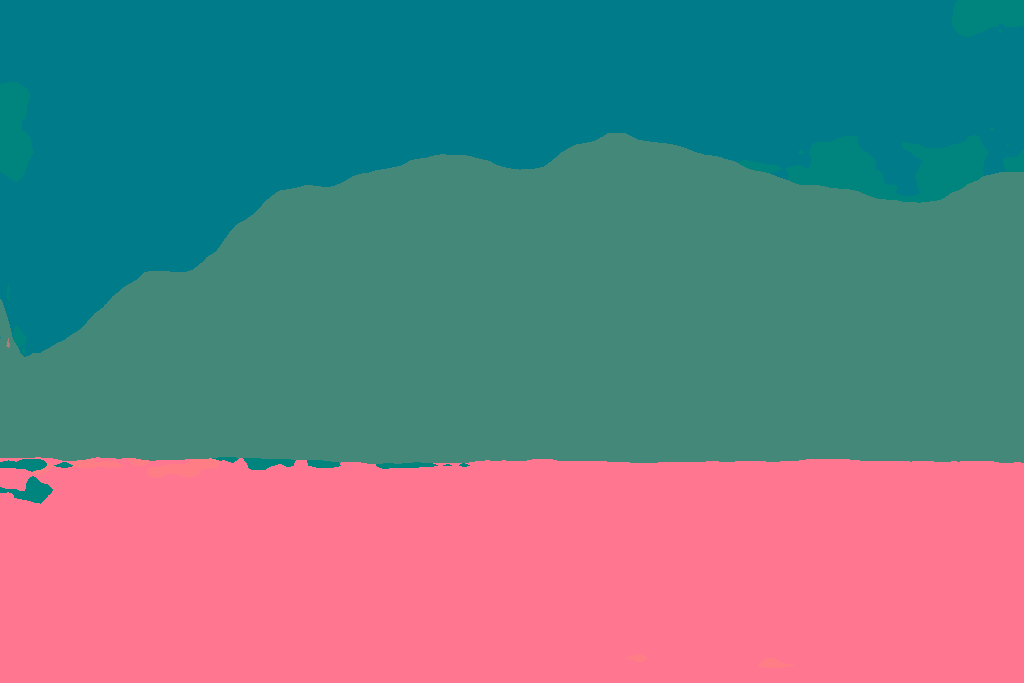

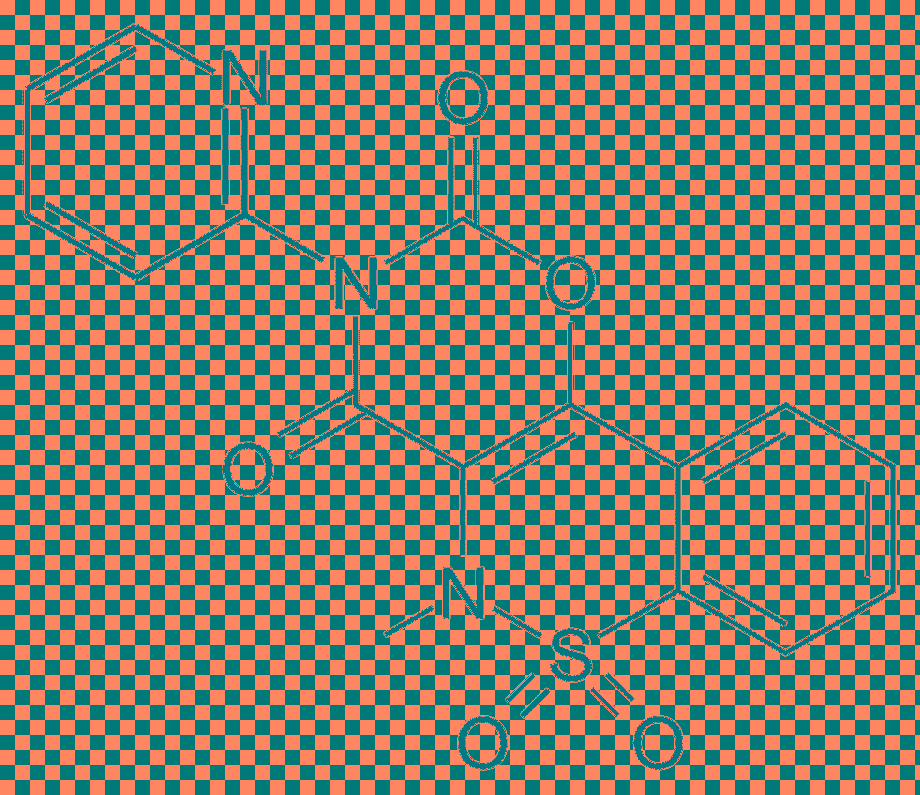

In [ ]:
show_segmentation(example)
# show_segmentation(example2)
show_segmentation(example3)

Our model also employs a VQGAN for the conditioning information, i.e. the segmentation in this example. Let's autoencode the segmentation map. Encoding returns both the quantized code and its representation in terms of indices of a learned codebook.

In [9]:
def autoencode(s):
  c_code, c_indices = model.encode_to_c(s)
  print("c_code", c_code.shape, c_code.dtype)
  print("c_indices", c_indices.shape, c_indices.dtype)
  assert c_code.shape[2]*c_code.shape[3] == c_indices.shape[0]
  segmentation_rec = model.cond_stage_model.decode(c_code)
  show_segmentation(torch.softmax(segmentation_rec, dim=1))

  return c_code, c_indices

c_code torch.Size([1, 256, 42, 64]) torch.float32
c_indices torch.Size([2688]) torch.int64


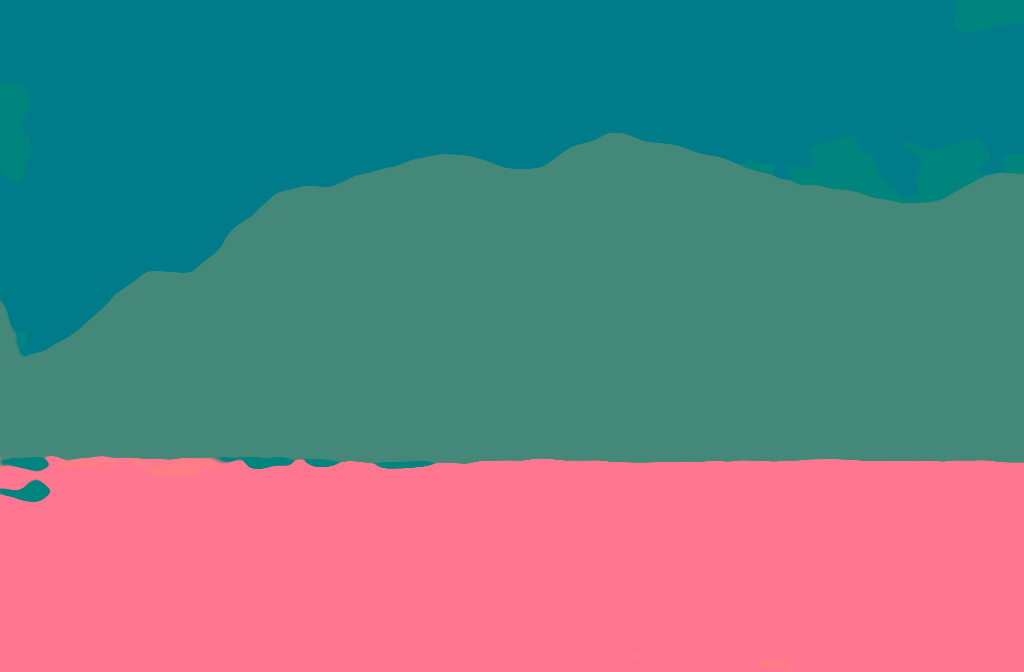

c_code torch.Size([1, 256, 49, 57]) torch.float32
c_indices torch.Size([2793]) torch.int64


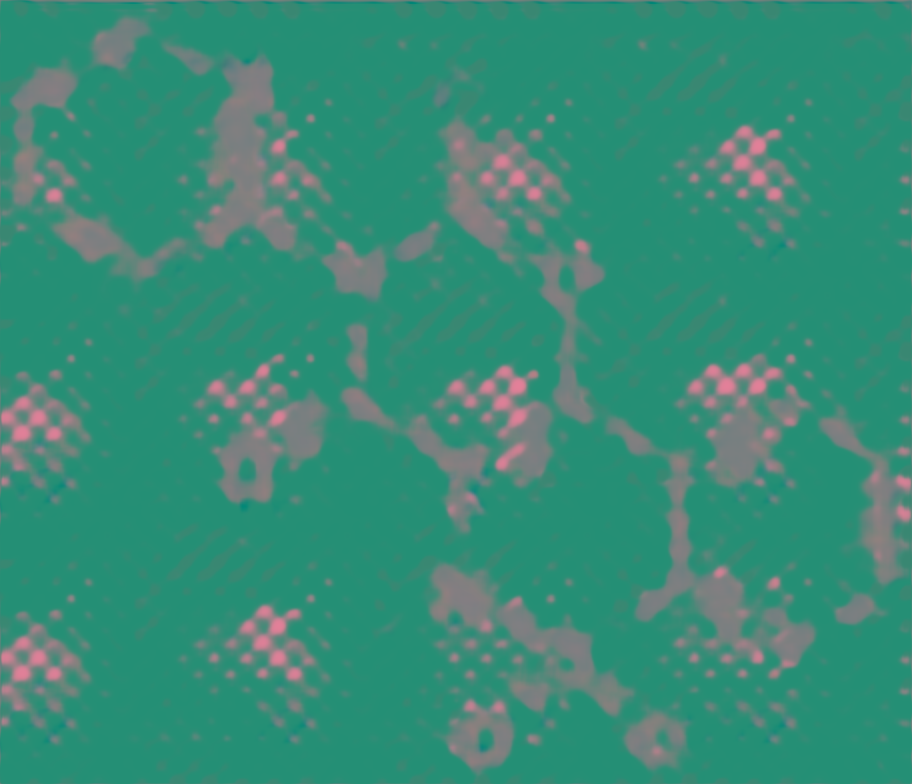

In [ ]:
c_code, c_indices = autoencode(example)
# c_code2, c_indices2 = autoencode(example2)
c_code3, c_indices3 = autoencode(example3)

Let's sample indices corresponding to codes from the image VQGAN given the segmentation code. We init randomly and take a look.

In [10]:
def show_image(s):
  s = s.detach().cpu().numpy().transpose(0,2,3,1)[0]
  s = ((s+1.0)*127.5).clip(0,255).astype(np.uint8)
  s = Image.fromarray(s)
  display(s)

def to_img(c_indices, c_code):
  codebook_size = config.model.params.first_stage_config.params.embed_dim
  z_indices_shape = c_indices.shape
  z_code_shape = c_code.shape
  z_indices = torch.randint(codebook_size, z_indices_shape, device=model.device)
  x_sample = model.decode_to_img(z_indices, z_code_shape)

  return z_indices_shape, z_code_shape, z_indices, x_sample

In [ ]:
z_indices_shape, z_code_shape, z_indices, x_sample = to_img(c_indices, c_code)
# z_indices_shape2, z_code_shape2, z_indices2, x_sample2 = to_img(c_indices2, c_code2)
z_indices_shape3, z_code_shape3, z_indices3, x_sample3 = to_img(c_indices3, c_code3)

show_image(x_sample)
# show_image(x_sample2)
show_image(x_sample3)

Output hidden; open in https://colab.research.google.com to view.

## Sample an image

We use the transformer in a sliding window manner to sample all code entries sequentially. The code below assumes a window size of $16\times 16$.

In [11]:
from IPython.display import clear_output
import time

def generate_img(z_indices, c_indices, z_code_shape, x_sample, c_code):

  idx = z_indices
  idx = idx.reshape(z_code_shape[0],z_code_shape[2],z_code_shape[3])

  cidx = c_indices
  cidx = cidx.reshape(c_code.shape[0],c_code.shape[2],c_code.shape[3])

  temperature = 1.0
  top_k = 100
  update_every = 50

  start_t = time.time()
  for i in range(0, z_code_shape[2]-0):
    if i <= 8:
      local_i = i
    elif z_code_shape[2]-i < 8:
      local_i = 16-(z_code_shape[2]-i)
    else:
      local_i = 8
    for j in range(0,z_code_shape[3]-0):
      if j <= 8:
        local_j = j
      elif z_code_shape[3]-j < 8:
        local_j = 16-(z_code_shape[3]-j)
      else:
        local_j = 8

      i_start = i-local_i
      i_end = i_start+16
      j_start = j-local_j
      j_end = j_start+16
      
      patch = idx[:,i_start:i_end,j_start:j_end]
      patch = patch.reshape(patch.shape[0],-1)
      cpatch = cidx[:, i_start:i_end, j_start:j_end]
      cpatch = cpatch.reshape(cpatch.shape[0], -1)
      patch = torch.cat((cpatch, patch), dim=1)
      logits,_ = model.transformer(patch[:,:-1])
      logits = logits[:, -256:, :]
      logits = logits.reshape(z_code_shape[0],16,16,-1)
      logits = logits[:,local_i,local_j,:]

      logits = logits/temperature

      if top_k is not None:
        logits = model.top_k_logits(logits, top_k)

      probs = torch.nn.functional.softmax(logits, dim=-1)
      idx[:,i,j] = torch.multinomial(probs, num_samples=1)

      step = i*z_code_shape[3]+j
      if step%update_every==0 or step==z_code_shape[2]*z_code_shape[3]-1:
        x_sample = model.decode_to_img(idx, z_code_shape)
        clear_output()
        print(f"Time: {time.time() - start_t} seconds")
        print(f"Step: ({i},{j}) | Local: ({local_i},{local_j}) | Crop: ({i_start}:{i_end},{j_start}:{j_end})")
        show_image(x_sample)

Time: 570.9786531925201 seconds
Step: (34,12) | Local: (8,8) | Crop: (26:42,4:20)


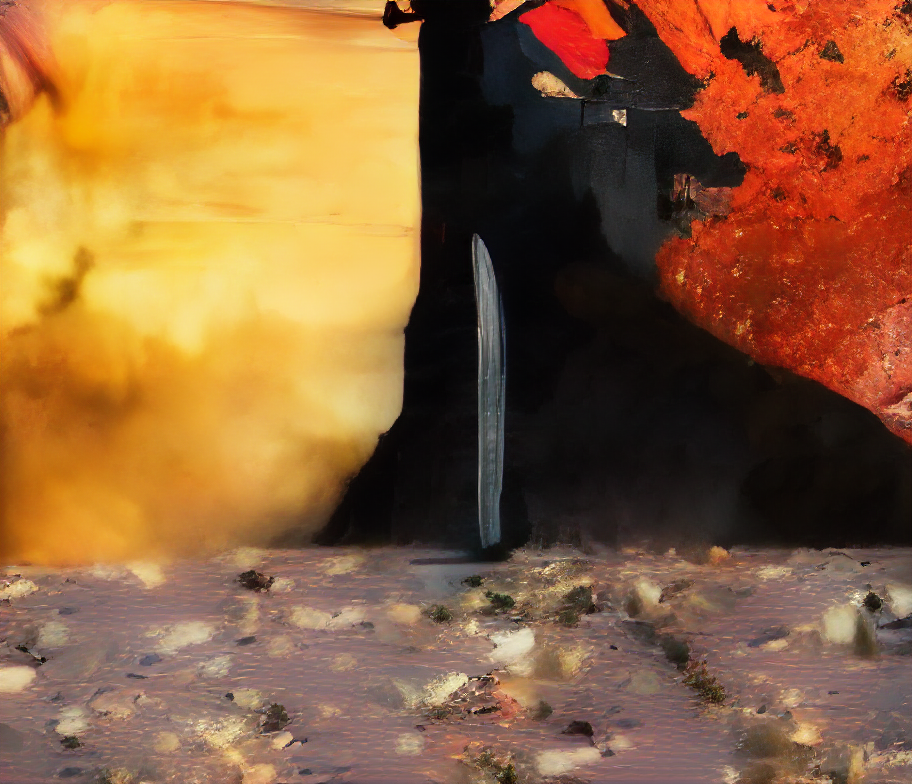

In [ ]:
generate_img(z_indices, c_indices, z_code_shape, x_sample, c_code)
#generate_img(z_indices2, c_indices2, z_code_shape2, x_sample2, c_code2)
generate_img(z_indices3, c_indices3, z_code_shape3, x_sample3, c_code3)

## Example with Chemical image

In [17]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


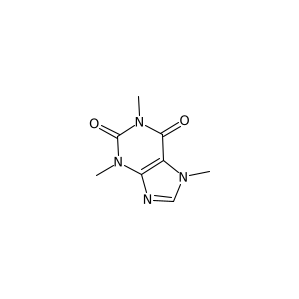

IndexError: ignored

In [20]:
from PIL import Image
import numpy as np
img_path="../drive/MyDrive//4_ING_INFORMATICA/tfg/tfg/experiments/decimer/caffeine.png"
img = Image.open(img_path)
display(img)

img = np.array(img)
img = np.eye(182)[img]
img = torch.tensor(img.transpose(2,0,1)[None]).to(dtype=torch.float32, device=model.device)

/content/taming-transformers


In [18]:
!ls

'=1.0.8'   configs	      License.txt   __pycache__   setup.py
'=2.0.0'   data		      logs	    README.md	  taming
 assets    environment.yaml   main.py	    scripts
